<a id="task"></a>
## Задачи
Обработать данные о вакансиях. Проанализировать зарплаты и посмотреть на зависимости.

Составить ТОПы ключевых навыков и самых часто повторяющихся слов в описаниях вакансий. Определить отличия навыков в зависимости от уровня профессионализма. 

Написать общий вывод.

In [24]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tabulate import tabulate
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype") 
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "DeprecationWarning")


pd.set_option('display.max_columns', None)

C:\Users\Arkhipov\AppData\Local\Temp\ipykernel_49020\525284759.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Функции для работы с выводом
Для удобного отображения данных

### Функция для удобного вывода таблиц рядом с друг другом.

In [89]:

def display_side_by_side(series_list: list, title: str):
    tables = []

    for series in series_list:
        # Преобразование объектов Series во временные DataFrame
        df = pd.DataFrame(series.describe())

        # Форматирование чисел в таблицах
        for column in df.columns:
            df[column] = df[column].apply(lambda x: '{:,.0f}'.format(x))

        # Конвертация таблиц в формат, подходящий для tabulate
        table = tabulate(df, headers='keys', tablefmt='pipe')
        tables.append(table.split('\n'))

    # Определение максимального числа строк в таблицах
    max_rows = max(len(table) for table in tables)

    # Заполнение таблиц строками до одинаковой длины
    for table in tables:
        table += [''] * (max_rows - len(table))

    # Объединение строк таблиц в одну таблицу
    combined_table = f"| {title} |\n" + '\n'.join('|'.join(row) for row in zip(*tables))
    print(combined_table)

<a id="data_processing"></a>
## Анализ данных
Собранны данные по запросу 
- профессия - все вакансии в которых в названии которых есть слово `Android`
- район поиска - `Россия`


In [3]:
try:
    df = pd.read_csv('hh_result.csv')
    print('DataFrame has been uploaded!')
    df.sample(5)
except:
    print('CSV file no found :(')

DataFrame has been uploaded!


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            524 non-null    int64  
 1   premium       524 non-null    bool   
 2   vacancy_name  524 non-null    object 
 3   city          524 non-null    object 
 4   salary        524 non-null    bool   
 5   salary_from   116 non-null    float64
 6   salary_to     94 non-null     float64
 7   currency      145 non-null    object 
 8   experience    524 non-null    object 
 9   schedule      524 non-null    object 
 10  employment    524 non-null    object 
 11  description   524 non-null    object 
 12  skills        347 non-null    object 
 13  employer      524 non-null    object 
 14  publish_date  524 non-null    object 
 15  vacancy_url   524 non-null    object 
 16  has_test      524 non-null    bool   
dtypes: bool(3), float64(2), int64(1), object(11)
memory usage: 59.0+ KB


В таблице есть пропуски в данных о зарплате и ключевых умениях. Остальные данные заполнены полностью. Связано это с тем что на сервисе hh.ru столбцы в которых есть пропуски не являются обязательными к заполнению.

<a id="data_drop_dublicates"></a>
### Удаление явных дубликатов и мусора

In [5]:
display(df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

0

In [6]:
# Создаем DataFrame с отфильтрованными строками
df_filtered = df[df['vacancy_name'].str.contains('курьер', case=False) | df['vacancy_name'].str.contains('ремонт', case=False) | df['vacancy_name'].str.contains('продавец', case=False)]

# Находим индексы строк в исходном DataFrame, которые нужно удалить
indexes_to_drop = df_filtered.index

# Удаляем строки из исходного DataFrame
df = df.drop(indexes_to_drop)

# Сбрасываем индексы
df = df.reset_index(drop=True)

<a id="data_processing_usd"></a>
### Обработка валютных вакансий
Вакансий в которых зарплата не в рублях, очень мало. Удаляем эти строки.

In [7]:
display(df['currency'].unique())
display(df.query('currency=="USD"')['currency'].count())
df = df.drop(df.query('currency=="USD"').index).reset_index(drop=True)
display(df['currency'].unique())

array([nan, 'RUB', 'USD'], dtype=object)

8

array([nan, 'RUB'], dtype=object)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            490 non-null    int64  
 1   premium       490 non-null    bool   
 2   vacancy_name  490 non-null    object 
 3   city          490 non-null    object 
 4   salary        490 non-null    bool   
 5   salary_from   85 non-null     float64
 6   salary_to     67 non-null     float64
 7   currency      111 non-null    object 
 8   experience    490 non-null    object 
 9   schedule      490 non-null    object 
 10  employment    490 non-null    object 
 11  description   490 non-null    object 
 12  skills        339 non-null    object 
 13  employer      490 non-null    object 
 14  publish_date  490 non-null    object 
 15  vacancy_url   490 non-null    object 
 16  has_test      490 non-null    bool   
dtypes: bool(3), float64(2), int64(1), object(11)
memory usage: 55.2+ KB


<a id="data_add_new_column"></a>
### Добавляем столбец со средней зарплатой
Создаем новую колонку с средней зарплатой

In [9]:
def salary_mean(row):
    fr = np.isnan(row['salary_from'])
    to = np.isnan(row['salary_to'])
    
    if fr and to:
        return None
    elif fr == False and to == False:
        return (row['salary_from']+row['salary_to'])/2
    elif fr  and to == False:
        return row['salary_to']
    elif fr == False and to:
        return row['salary_from']

Вызываем функцию расчета и добавления столбца со средней запрлатой

In [10]:
df['salary_mean'] = df.apply(salary_mean, axis=1) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            490 non-null    int64  
 1   premium       490 non-null    bool   
 2   vacancy_name  490 non-null    object 
 3   city          490 non-null    object 
 4   salary        490 non-null    bool   
 5   salary_from   85 non-null     float64
 6   salary_to     67 non-null     float64
 7   currency      111 non-null    object 
 8   experience    490 non-null    object 
 9   schedule      490 non-null    object 
 10  employment    490 non-null    object 
 11  description   490 non-null    object 
 12  skills        339 non-null    object 
 13  employer      490 non-null    object 
 14  publish_date  490 non-null    object 
 15  vacancy_url   490 non-null    object 
 16  has_test      490 non-null    bool   
 17  salary_mean   111 non-null    float64
dtypes: bool(3), float64(3), int64(

<a id="data_analysis_salary"></a>
## Анализ зарплат "от/до"

 ~~Для вывода графиков сделаем срез, убрав экстримальные значения в зарплатах.~~

In [11]:
# dg = df.query('salary_from<200_000 & salary_to<300_000 & currency=="RUB"')
dg = df

<a id="data_salary_from_to"></a>
### Распределие зарплат "от/до"

| Describe |
|       | salary_from   |||       | salary_to   |
|:------|:--------------|||:------|:------------|
| count | 8             ||| count | 8           |
| mean  | 145,896       ||| mean  | 205,943     |
| std   | 135,273       ||| std   | 155,622     |
| min   | 85            ||| min   | 67          |
| 25%   | 70,862        ||| 25%   | 97,622      |
| 50%   | 120,000       ||| 50%   | 206,989     |
| 75%   | 176,950       ||| 75%   | 262,500     |
| max   | 430,000       ||| max   | 500,000     |


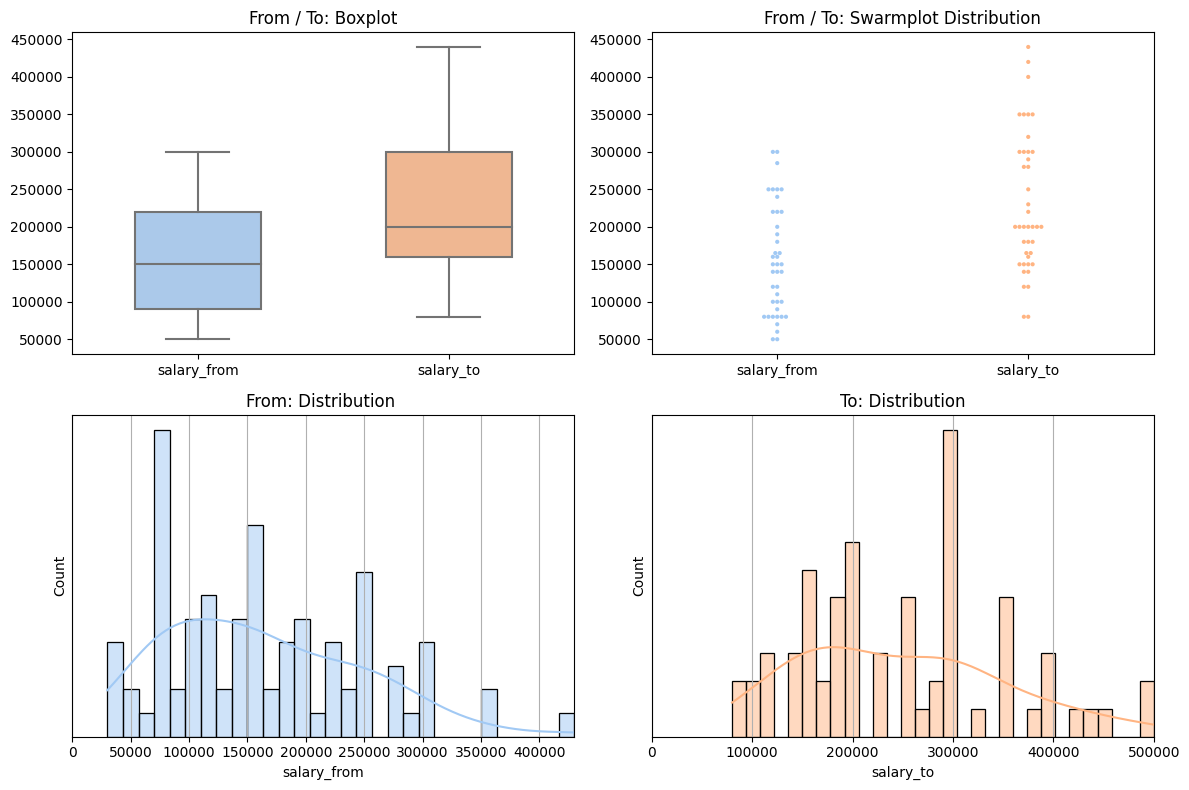

In [91]:
display_side_by_side([dg['salary_from'].describe(),dg['salary_to'].describe()],"Describe" )


sns.set_palette("pastel")
fz = plt.figure('Salary plots', figsize=(12, 8), dpi=100)

fz.add_subplot(2, 2, 1)
plt.title('From / To: Boxplot')
sns.boxplot(data=dg[['salary_from', 'salary_to']].dropna(), width=0.5)

fz.add_subplot(2, 2, 2)
plt.title('From / To: Swarmplot Distribution')
sns.swarmplot(data=dg[['salary_from', 'salary_to']].dropna(), size=3)

fz.add_subplot(2, 2, 3)
plt.title('From: Distribution ')
sns.histplot(dg['salary_from'].dropna(), bins=30, color='C0', kde=True)
plt.grid(True)
plt.xlim([0, dg['salary_from'].max()])
plt.yticks([], [])

fz.add_subplot(2, 2, 4)
plt.title('To: Distribution')
sns.histplot(dg['salary_to'].dropna(), bins=30, color='C1', kde=True)
plt.grid(True)
plt.xlim([0, dg['salary_to'].max()])
plt.yticks([], [])
plt.tight_layout()

По графикам видно:


Ожидаемо видно что чем выше зарплата тем меньше вакансий.

<a id="data_salary_to_lvl"></a>
### Зависимость зарплаты "от/до" от опыта

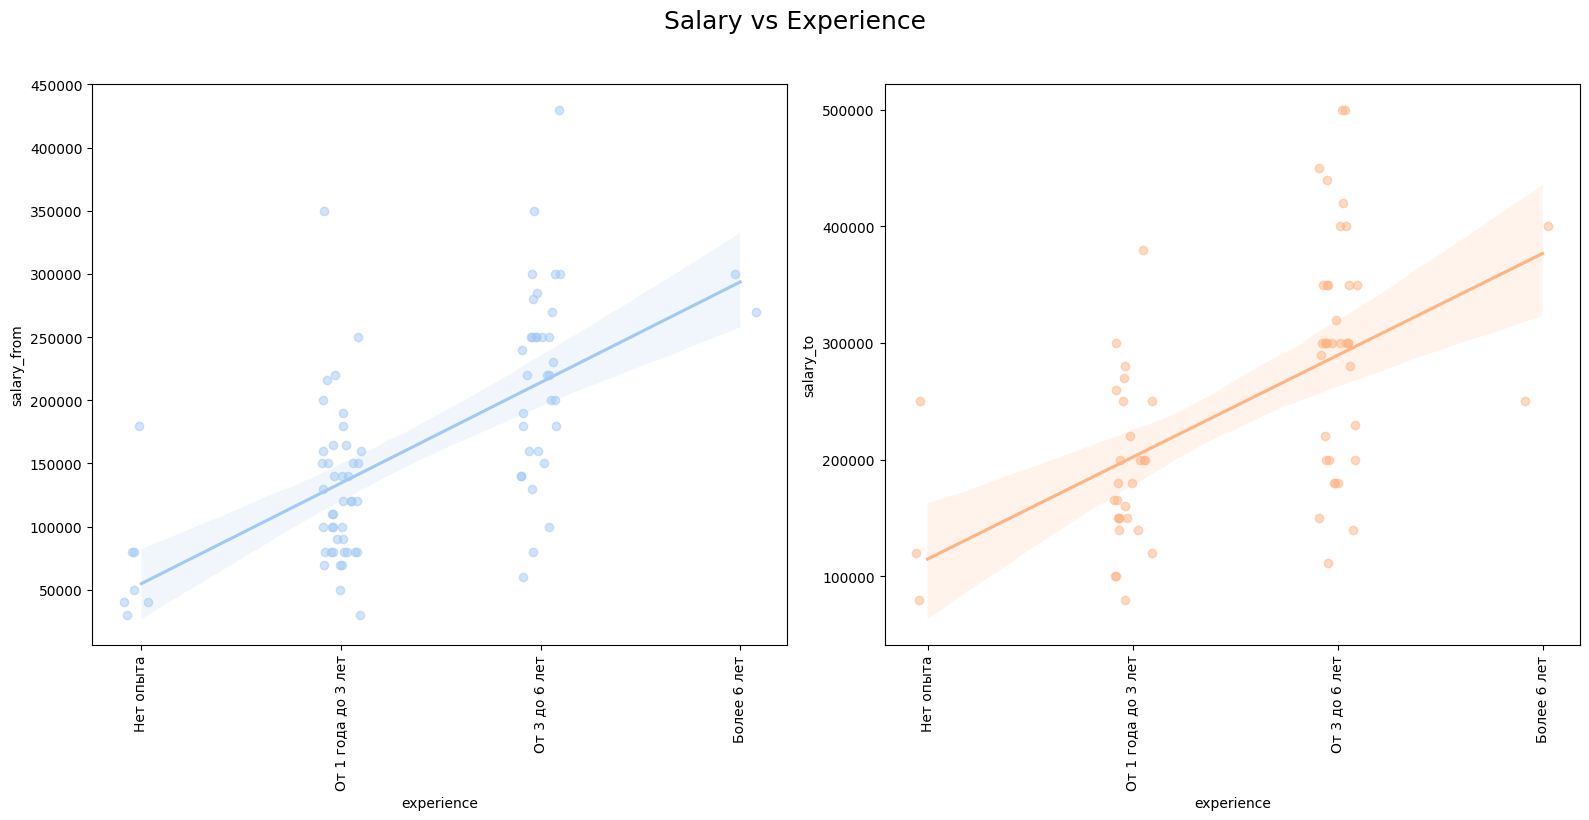

In [13]:
sns.set_palette("pastel")
exp_dic = {'Нет опыта': 0, 'От 1 года до 3 лет': 1, 'От 3 до 6 лет': 2, 'Более 6 лет': 3}
experience = dg['experience'].map(exp_dic)


fig = plt.figure(figsize=(16, 8), dpi=100)
plt.suptitle('Salary vs Experience', y=1.02, fontsize=18)

fig.add_subplot(1, 2, 1)
sns.regplot(x=experience, y=dg['salary_from'], color="C0", x_jitter=.1, scatter_kws={'alpha':0.5})
plt.xticks(list(range(4)), labels=exp_dic.keys(), rotation='vertical')

fig.add_subplot(1, 2, 2)
sns.regplot(x=experience, y=dg['salary_to'], color="C1", x_jitter=.1, scatter_kws={'alpha':0.5})
plt.xticks(list(range(4)), labels=exp_dic.keys(), rotation='vertical')

plt.tight_layout()

По графикам можно определить:
- больше всего вакансий с требованием опыта `от 1 до 3` и `от 3 до 6`
- хорошо видна корреляция `чем больше опыта, тем выше зарплата`

<a id="data_salary_mean"></a>
### Анализ сренего зраплаты

In [14]:
df['salary_mean'].dropna().size

111

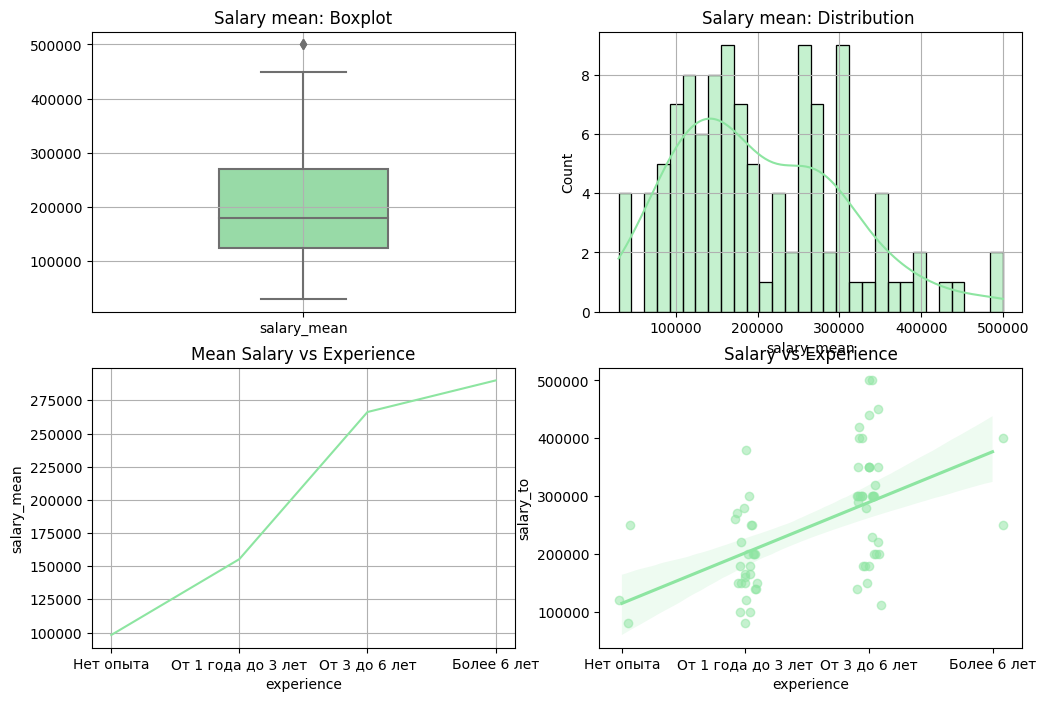

In [15]:
sns.set_palette("pastel")
fz = plt.figure('Salary mean plots', figsize=(12, 8), dpi=100)

exp_dic = {'Нет опыта': 0, 'От 1 года до 3 лет': 1, 'От 3 до 6 лет': 2, 'Более 6 лет': 3}
experience = dg['experience'].map(exp_dic)


fz.add_subplot(2, 2, 1);
plt.title('Salary mean: Boxplot');
sns.boxplot(data=dg[['salary_mean']].dropna(), width=0.4, color='C2');
plt.grid(True);

fz.add_subplot(2, 2, 2);
plt.title('Salary mean: Distribution ');
sns.histplot(dg['salary_mean'].dropna(), bins=30, color='C2', kde=True);
plt.grid(True);

fz.add_subplot(2, 2, 3);
plt.title('Mean Salary vs Experience');
sns.lineplot(data=dg.pivot_table(index= 'experience', values='salary_mean').sort_values(by='salary_mean'),
            x="experience", y="salary_mean",color="C2");
plt.grid(True);

fz.add_subplot(2, 2, 4);
plt.title('Salary vs Experience');
sns.regplot(x=experience, y=dg['salary_to'], color="C2", x_jitter=.1, scatter_kws={'alpha':0.5});
plt.xticks(list(range(4)), labels=exp_dic.keys());


<a id="data_salary_conclusion"></a>
### Вывод
Проанализировав данные по `от/до` и `среднего по ним` зарплат.

<a id="data_salary_city"></a>
### Зависимость зарплаты от города

Для анализа зависимости зарплаты от города, для начала найдем топ 10 самых частых городов в датафрейме.

In [16]:
top_10 = df[df.city.isin(df['city'].value_counts()[0:10].index)]
top_10.pivot_table(index='city',values='vacancy_name',aggfunc='count').sort_values(by='vacancy_name',ascending=False)

,vacancy_name
city,
Москва,266
Санкт-Петербург,90
Новосибирск,17
Казань,12
Нижний Новгород,10
Екатеринбург,8
Ростов-на-Дону,8
Томск,5
Калининград,4


В топ 10 ожидаемо и с огромным перевесом, попала Москва и Петербург. А так же другие города миллионники. Для анализа возьмем следующие срезы:
- Москва
- Петербург
- все остальные города

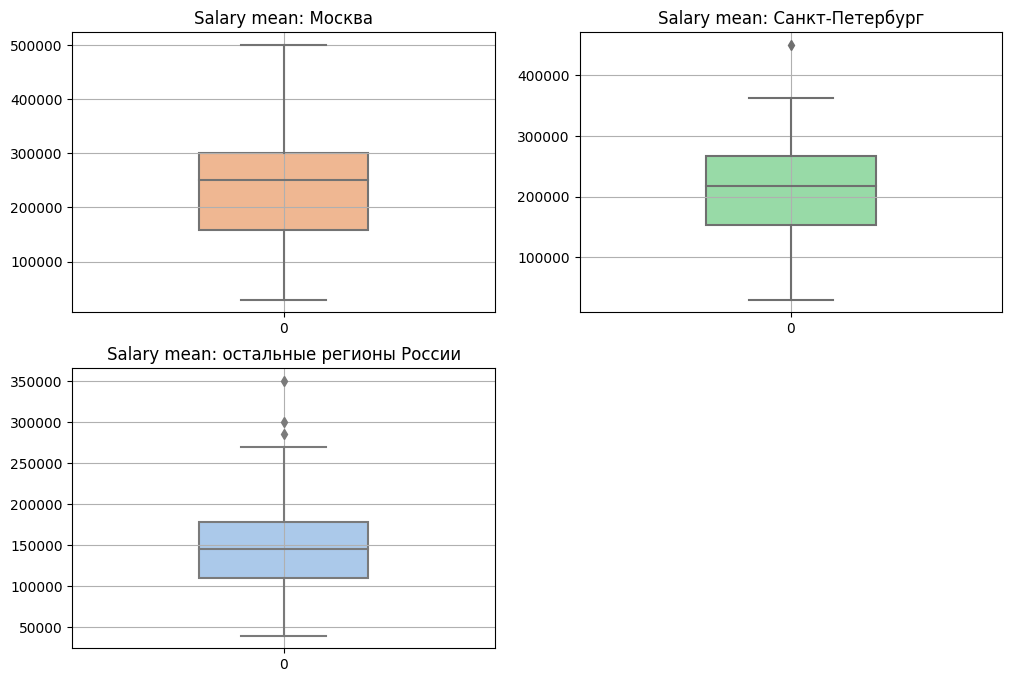

In [17]:
sns.set_palette("pastel")
fz = plt.figure('Salary plots', figsize=(12, 8), dpi=100)

fz.add_subplot(2, 2, 1)
plt.title('Salary mean: Москва')
sns.boxplot(data=dg.query('city == "Москва"')
                        ['salary_mean'].dropna().reset_index(drop=True), width=0.4,  color='C1');
plt.grid(True)

fz.add_subplot(2, 2, 2)
plt.title('Salary mean: Санкт-Петербург')
sns.boxplot(data=df.query('city == "Санкт-Петербург"')
                        ['salary_mean'].dropna().reset_index(drop=True), width=0.4,  color='C2');
plt.grid(True)


fz.add_subplot(2, 2, 3)
plt.title('Salary mean: остальные регионы России')
sns.boxplot(data=dg.query('city not in ["Москва", "Санкт-Петербург"]')
                        ['salary_mean'].dropna().reset_index(drop=True), width=0.4,  color='C0');
plt.grid(True)

<a id="data_salary_city_conclusion"></a>
### Вывод
По графикам видна разница зарплат в Москве и Петербурге и остальных регионах России.

<a id="data_skills_description"></a>
## Анализ навыков и описания вакансий

#### Анализ ключевых навыков
Функция для анализа ключевых навыков и составления списка (ключевой навык - количество повторений)

In [18]:
# принимает:
# 'df' - таблица с данными

# возвращает:
# Series с отсортированными значениями (ключевой навых - количество повторений)


def top_skills(df):
    # переводим ключевые навыки из Series в List
    skills_df = df['skills'].to_list()
    # список для всех ключевых навыков со всех вакансий
    skills = []
    # заполняем список всех ключевых навыков
    for skill in skills_df:
        if skill == skill:
            for el in skill[1:-1].split(', '):
                if el != '':
                    skills.append(re.sub('\'', '', el.lower()))

    # выбираем все уникальные значения ключевых навыков
    set_skills = set(skills)
    # создаем словарь с уникальными словами и их количеством повторений
    dct_skills = {el:skills.count(el) for el in set_skills}
    # сортируем данные
    srt_skills = dict(sorted(dct_skills.items(), key=lambda x: x[1], reverse=True))
    # возвращаем отсортированные данные (ключевой навык - количество повторений)
    return pd.Series(srt_skills, name='skills')

<a id="data_description"></a>
### Анализ описания вакансий
Функция для анализа всех слов в описании вакансий, на выбор англ или рус языка. И составления списка (слово - количество повторений)

In [19]:
# принимает:
# 'df' - таблица с данными
# 'lang' - на каком языке ищем повторы слов
# 'word_length' - пороговое кол-во символов в слове

# возвращает:
# Series с отсортированными значениями (слово - количество повоторений) 

def top_description_words(df, lang='en', word_length=2):
    # на каком языке искать слова
    if lang == 'ru':
        lang = '[а-яА-Я]+'
    else:
        lang = '[a-zA-Z]+'
    
    # преобразуем series в list
    words_df = df['description'].to_list()
    # убираем лишнее из строки и переводим все символы в нижний регистр
    words_ls = ' '.join([re.sub('quot', ' ', 
                         re.sub(' +', ' ', 
                         re.sub('\d+', '', 
                         el.strip().lower()))) 
                         for el in words_df])
    # поиск все отдельных слов в зависимости от выбранного языка
    words_re = re.findall(lang, words_ls)
    # отбрасываем все слова короче word_length символов
    words_l2 = [el for el in words_re if len(el) > word_length]
    # отделяем все уникальные слова
    words_st = set(words_l2)
    # создаем словарь с уникальными словами и их количеством повторений
    words_cnt = {el : words_l2.count(el) for el in words_st}
    # возращаем Series с отсортированными значениями (слово - количество повоторений)
    return pd.Series(dict(sorted(words_cnt.items(), key=lambda x: x[1], reverse=True)))

Ищем самые часто повторяющиеся слова:
- на русском
- на английском

**Очень долго обрабатывает, лучше запустить 1 раз**

In [20]:
# поиск самых часто повторяющихся ключевых навыков
top_ds_skills = top_skills(df)
# поиск самых часто повторяющихся слов в описании вакансии на английском
top_ds_en_words = top_description_words(df, 'en')
# поиск самых часто повторяющихся слов в описании вакансии на русском
top_ds_ru_words = top_description_words(df, 'ru', 3)

Выводим на экран самые часто встречающиеся:
- ключевые навыки
- повторяющиеся англ слова в описании вакансий
- повторяющиеся рус слова в описании вакансий

In [21]:
count = 20

sk = top_ds_skills.head(count)
en = top_ds_en_words.head(count)
ru = top_ds_ru_words.head(count)

display_side_by_side([pd.DataFrame({'skills':sk.index, 'count':sk.values}),
                      pd.DataFrame({'words':en.index, 'count':en.values}),
                      pd.DataFrame({'words':ru.index,'count':ru.values})],
                     ['Top skills:', 'Top EN description words:', 'Top RU description words:'], 10) 

,skills,count
0,kotlin,263
1,android,252
2,android sdk,159
3,java,143
4,git,84
5,mvvm,52
6,ооп,38
7,rxjava,28
8,coroutines,26
9,retrofit,26


<a id="data_skills_to_lvl"></a>
### Сравнение ключевых навыков между уровнями вакансий
Сравниваем ключевые навыки и самые часто повторяющиеся англ слова в вакансиях в зависимости от уровня работника
- junior - "Нет опыта"
- middle - "От 1 года до 3 лет"
- senior - "От 3 до 6 лет"
- lead - "Более 6 лет"

**Очень долго обрабатывает, лучше запустить 1 раз**

In [22]:
df_jun = df.query('experience == "Нет опыта"')
df_mid = df.query('experience == "От 1 года до 3 лет"')
df_sen = df.query('experience == "От 3 до 6 лет"')
df_lead = df.query('experience == "Более 6 лет"')

count = 10

jun_skills = top_skills(df_jun).head(count)
mid_skills = top_skills(df_mid).head(count)
sen_skills = top_skills(df_sen).head(count)
lead_skills = top_skills(df_lead).head(count)

jun_en_words = top_description_words(df_jun).head(count)
mid_en_words = top_description_words(df_mid).head(count)
sen_en_words = top_description_words(df_sen).head(count)
lead_en_words = top_description_words(df_lead).head(count)

jun_ru_words = top_description_words(df_jun,'ru',3).head(count)
mid_ru_words = top_description_words(df_mid,'ru',3).head(count)
sen_ru_words = top_description_words(df_sen,'ru',3).head(count)
lead_ru_words = top_description_words(df_lead,'ru',3).head(count)

In [23]:
display_side_by_side([pd.DataFrame({'skills':jun_skills.index, 'count':jun_skills.values}),
                      pd.DataFrame({'words':jun_en_words.index, 'count':jun_en_words.values}),
                      pd.DataFrame({'words':jun_ru_words.index, 'count':jun_ru_words.values})],
                     ['Top skills for junior', 'Top en words for junior', 'Top ru words for junior'], 10) 
display_side_by_side([pd.DataFrame({'skills':mid_skills.index, 'count':mid_skills.values}),
                      pd.DataFrame({'words':mid_en_words.index, 'count':mid_en_words.values}),
                      pd.DataFrame({'words':mid_ru_words.index, 'count':mid_ru_words.values})],
                     ['Top skills for middle', 'Top en words for middle', 'Top ru words for middle'], 10) 
display_side_by_side([pd.DataFrame({'skills':sen_skills.index, 'count':sen_skills.values}),
                      pd.DataFrame({'words':sen_en_words.index, 'count':sen_en_words.values}),
                      pd.DataFrame({'words':sen_ru_words.index, 'count':sen_ru_words.values})],
                     ['Top skills for senior', 'Top en words for senior', 'Top ru words for senior'], 10) 
display_side_by_side([pd.DataFrame({'skills':lead_skills.index, 'count':lead_skills.values}),
                      pd.DataFrame({'words':lead_en_words.index, 'count':lead_en_words.values}),
                      pd.DataFrame({'words':lead_ru_words.index, 'count':lead_ru_words.values})],
                     ['Top skills for lead', 'Top en words for lead', 'Top ru words for lead'], 10) 

,skills,count
0,android,10
1,kotlin,8
2,ооп,3
3,git,2
4,java,2
5,android sdk,2
6,rx,2
7,разработка по,1
8,firebase,1
9,оптимизация кода,1


,skills,count
0,android,82
1,kotlin,79
2,java,47
3,android sdk,47
4,git,31
5,mvvm,17
6,ооп,14
7,retrofit,11
8,mvp,8
9,английский язык,8


,skills,count
0,kotlin,163
1,android,150
2,android sdk,99
3,java,85
4,git,48
5,mvvm,33
6,rxjava,19
7,coroutines,18
8,ооп,18
9,dagger 2,17


,skills,count
0,kotlin,13
1,android sdk,11
2,android,10
3,java,9
4,aosp,4
5,c++,3
6,git,3
7,архитектура,3
8,sqlite,3
9,ооп,3


<a id="data_skills_conclusion"></a>
### Вывод

<a id="final_conclusion"></a>
## Общие выводы